In [33]:
!pip install numpy pandas scikit-learn tensorflow pillow matplotlib opencv-python

In [34]:
# Célula 1: Importação das bibliotecas necessárias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
import os

In [35]:
# Definindo o caminho do arquivo zipado
#zip_path = '/content/sub_images.zip'
extract_path = os.path.join('..', '..', 'PREPROCESSAMENTO', 'sub_images')

# Descompactando o arquivo
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
 #   zip_ref.extractall(extract_path)

# Verificando o conteúdo da pasta descompactada
os.listdir(extract_path)

['ASC-H',
 'ASC-US',
 'HSIL',
 'LSIL',
 'Negative for intraepithelial lesion',
 'SCC']

In [36]:
def load_data(data_path):
    X = []
    y = []
    label_map = {}  # Dicionário para mapear nomes das pastas para rótulos numéricos
    print("Carregando imagens...")
    for i, label in enumerate(os.listdir(data_path)):
        label_path = os.path.join(data_path, label)
        if os.path.isdir(label_path):
            print(f"Processando imagens para a classe: {label}")
            label_map[label] = i  # Adiciona a classe ao dicionário de mapeamento
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                # Verificando se o caminho é um arquivo e se é uma imagem válida
                if os.path.isfile(img_path) and any(img_path.endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
                    img = Image.open(img_path).convert('L')  # Convertendo a imagem para grayscale
                    img = img.resize((16, 8))  # Redimensionando a imagem para 16x8
                    img_array = np.array(img).reshape(16, 8, 1)  # Transformando a imagem em um array numpy
                    X.append(img_array)
                    y.append(i)  # Usando o índice da classe como rótulo
                else:
                    print(f"Warning: {img_path} não é um arquivo de imagem válido.")
    if not X:
        raise ValueError("Nenhuma imagem válida encontrada.")
    if not y:
        raise ValueError("Nenhum rótulo encontrado.")
    print("Carregamento de imagens concluído.")
    X = np.array(X)
    y = np.array(y)
    return X, y, label_map


In [37]:
# Carregando os dados
X, y, label_map = load_data(extract_path)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Carregando imagens...
Processando imagens para a classe: ASC-H
Processando imagens para a classe: ASC-US
Processando imagens para a classe: HSIL
Processando imagens para a classe: LSIL
Processando imagens para a classe: Negative for intraepithelial lesion
Processando imagens para a classe: SCC
Carregamento de imagens concluído.


In [38]:
# Classificador Raso: SVM
# Redimensionando os dados para o formato 2D (necessário para o SVM)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Treinando o SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_flat, y_train)

# Prevendo no conjunto de teste
y_pred_svm = svm_model.predict(X_test_flat)

# Avaliando o modelo SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia do SVM: {svm_accuracy:.2f}')


Acurácia do SVM: 0.25


In [39]:
# Célula 4: Classificador Profundo: ResNet50
# Verificar o número de classes em y_train
num_classes = len(np.unique(y_train))

# Convertendo rótulos para one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=num_classes) # antes num_classes=2 -> tem mais do que 2 classes
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Redimensionando as imagens para 32x32
x_train_resized = np.array([cv2.resize(img, (32, 32)) for img in X_train]) # redefinir o tamanho pq o resnet precisa ser 32x32 pelo menos
x_test_resized = np.array([cv2.resize(img, (32, 32)) for img in X_test])

# Expandindo a dimensão para incluir o canal de cor
x_train_resized = np.expand_dims(x_train_resized, axis=-1)
x_test_resized = np.expand_dims(x_test_resized, axis=-1)

# Construindo o modelo ResNet50
input_shape = (32, 32, 1) # antes era (16,8,1) -> tem que ser 32x32 pelo menos
resnet_model = ResNet50(include_top=False, weights=None, input_shape=input_shape)
x = layers.GlobalAveragePooling2D()(resnet_model.output)
output = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=resnet_model.input, outputs=output)

# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Definindo o callback de checkpoint para salvar o melhor modelo
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                              save_best_only=True, 
                              monitor='val_accuracy', 
                              mode='max', 
                              verbose=1)
# Adicionando o callback de checkpoint na lista de callbacks
callbacks_list = [checkpoint]

In [40]:
# Treinando o modelo ResNet50 com checkpoint
history = model.fit(x_train_resized, y_train_cat, epochs=10, batch_size=32, validation_data=(x_test_resized, y_test_cat), validation_split=0.2, callbacks=callbacks_list)

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 3.4197 - accuracy: 0.2188
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_model.h5
3/3 [==============================] - 71s 7s/step - loss: 3.4197 - accuracy: 0.2188 - val_loss: 3.3846 - val_accuracy: 0.2500
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 4.3990 - accuracy: 0.2083
Epoch 2: val_accuracy did not improve from 0.25000
3/3 [==============================] - 10s 3s/step - loss: 4.3990 - accuracy: 0.2083 - val_loss: 3.1347 - val_accuracy: 0.1667
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 4.1877 - accuracy: 0.3646
Epoch 3: val_accuracy did not improve from 0.25000
3/3 [==============================] - 10s 4s/step - loss: 4.1877 - accuracy: 0.3646 - val_loss: 4.8996 - val_accuracy: 0.1667
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 3.2794 - accuracy: 0.4792
Epoch 4: val_accuracy did not improve from 0.25000
3/3 [==========

In [41]:
# Célula 6: Avaliando o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(x_test_resized, y_test_cat)
print(f'Acurácia da ResNet50: {test_accuracy:.2f}')


1/1 [==============================] - 0s 290ms/step - loss: 4.4571 - accuracy: 0.2500


Acurácia da ResNet50: 0.25


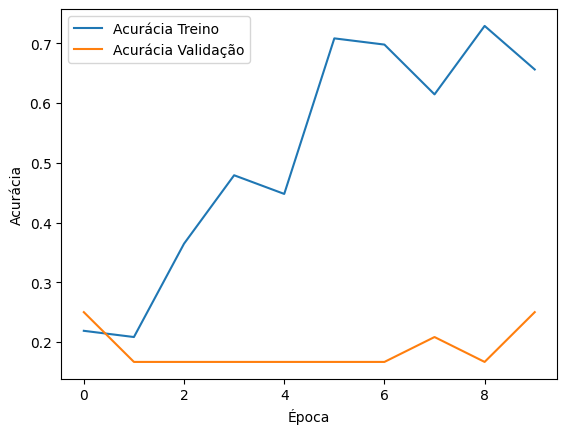

In [42]:
# Célula 7: Plotando a curva de treinamento
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()
